#This notebook implements a text mining sentiment analysis project 

##First we fetch the data from google drive

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from string import punctuation
import nltk
import re
import subprocess
from wordcloud import WordCloud 
from collections import Counter, defaultdict
nltk.download('punkt')
from nltk.corpus import stopwords
stop = stopwords.words("english")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lshpaner\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
pd.set_option('display.max_rows', None)

### Read data

In [ ]:
def download_gdrive(id, print_stout=True):
  coomand = 'gdown https://drive.google.com/uc?id={}'.format(id)
  returned_value = subprocess.run(coomand, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
  if print_stout: print(returned_value.stdout.decode("utf-8"))
  else: print("Download Complete")


train_data = download_gdrive("10rDgl5zAvUdVgSoVngHfwJnf8I1tdpZi", print_stout=True)
test_data = download_gdrive("10qeDcgwdJC76Nv5cCj6WsUYjD6846fEL", print_stout=True)

In [3]:
columns = ['polarity', 'tweetid', 'date', 'query_name', 'user', 'text']
dftrain = pd.read_csv('train_data.csv',
                      header = None,
                      encoding ='ISO-8859-1')
dftest = pd.read_csv('test_data.csv',
                     header = None,
                     encoding ='ISO-8859-1')
dftrain.columns = columns
dftest.columns = columns

In [4]:
dftrain = dftrain.sample(10000)

### Text pre-processing

In [5]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

class PrePreprocess(object):
    user_pat = '(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)'
    http_pat = '(https?:\/\/(?:www\.|(?!www))[^\s\.]+\.[^\s]{2,}|www\.[^\s]+\.[^\s]{2,})'
    repeat_pat, repeat_repl = "(.)\\1\\1+",'\\1\\1'
    def __init__(self):
        pass
    
    def transform(self, X):
        is_pd_series = isinstance(X, pd.core.frame.Series)
        if not is_pd_series:
            pp_text = pd.Series(X)
        else:
            pp_text = X
        pp_text = pp_text.str.replace(pat = self.user_pat, repl = 'USERNAME')
        pp_text = pp_text.str.replace(pat = self.http_pat, repl = 'URL')
        pp_text.str.replace(pat = self.repeat_pat, repl = self.repeat_repl)
        return pp_text
        
    def fit(self, X, y=None):
        return self


### Descriptive statistics 

In [6]:
import string
from string import punctuation

def descriptive_stats(tokens, top_num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity 
        (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of 
        tokens, number of unique tokens, lexical diversity, and number of
        characters. 
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = len("".join(tokens))
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

        
        # print the five most common tokens
        index = pd.Index(tokens)
        index.value_counts()
        df = pd.DataFrame(index.value_counts())
        top5 = df.head(top_num_tokens)
        print(top5.index.tolist())
        

            
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    

def count_words(df, column='tokens', preprocess=None, min_freq=1):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df#.sort_values('freq', ascending=False)


def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], 
            abs(words[largest[i]]*100.0/total)))
            
        
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
            
            
def wordcloud_clusters(model, vectors, features, no_top_words=5):
    for cluster in np.unique(model.labels_):
        size = {}
        words = vectors[model.labels_ == cluster].sum(axis=0).A[0]
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100,
                        width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Remove Stopwords
dftrain['text'] = dftrain['text'].apply(lambda x: ' '.join([word for word \
    in x.split() if word not in (stop)]))

p = PrePreprocess()
#PRE-Process step
dftrain['tokens'] = p.transform(dftrain['text'])
dftrain['tokens'] = dftrain['tokens'].apply(remove_punctuations)
##word_tokenize 
dftrain['tokens'] = dftrain.apply(lambda row: nltk.word_tokenize(row['tokens']), 
                                  axis=1)

print("DESCRIPTIVE STATS ON Tokens: ")
all = []
#on 100k data
#for li in dftrain['text'].sample(100).iteritems(): all += li[1]
#on all data  
for li in dftrain['tokens'].iteritems(): all += li[1]

descriptive_stats(all, verbose=True)
print("\n")

print("DESCRIPTIVE STATS ON SENTIMENT POLARITY:")
dftrain['polarity'].describe()


DESCRIPTIVE STATS ON Tokens: 
There are 86564 tokens in the data.
There are 18438 unique tokens in the data.
There are 430022 characters in the data.
The lexical diversity is 0.213 in the data.
['USERNAME', 'I', 'Im', 'URL', 'get']


DESCRIPTIVE STATS ON SENTIMENT POLARITY:


count    10000.000000
mean         1.967600
std          1.999838
min          0.000000
25%          0.000000
50%          0.000000
75%          4.000000
max          4.000000
Name: polarity, dtype: float64

In [8]:
dftrain.head(10)

,polarity,tweetid,date,query_name,user,text,tokens
876952,4,1684872650,Sat May 02 22:18:34 PDT 2009,NO_QUERY,cupcakeslam23,Eating Kettle Corn watching Transformers. Why?...,"[Eating, Kettle, Corn, watching, Transformers,..."
982013,4,1834166534,Mon May 18 01:53:08 PDT 2009,NO_QUERY,FuchsiaStiletto,@missmei Oh god - selfish him! I'm pretty fabb...,"[USERNAME, Oh, god, selfish, him, Im, pretty, ..."
495946,0,2185396325,Mon Jun 15 17:19:07 PDT 2009,NO_QUERY,libby_vandoris,*cries hysterically* IM A WHORE! *WAAAAAH*,"[cries, hysterically, IM, A, WHORE, WAAAAAH]"
443512,0,2067578521,Sun Jun 07 12:35:36 PDT 2009,NO_QUERY,RestoreMagnus,"Yesterday, good legs, missed leading group , f...","[Yesterday, good, legs, missed, leading, group..."
178467,0,1965978131,Fri May 29 16:53:48 PDT 2009,NO_QUERY,afadedlily,@POPPORNBLOG ouch picking nose count?,"[USERNAME, ouch, picking, nose, count]"
142808,0,1881567267,Fri May 22 05:00:33 PDT 2009,NO_QUERY,katem3,messed day already...stupid katelin,"[messed, day, alreadystupid, katelin]"
326568,0,2008261026,Tue Jun 02 13:51:51 PDT 2009,NO_QUERY,Torontonian_Fan,@erikalynnex3 ahahaha he's always 4gotten... p...,"[USERNAME, ahahaha, hes, always, 4gotten, prol..."
1129922,4,1975614413,Sat May 30 15:31:52 PDT 2009,NO_QUERY,drtns,@nkavassalis either fallen wagon BBQ,"[USERNAME, either, fallen, wagon, BBQ]"
1021016,4,1882485427,Fri May 22 06:57:35 PDT 2009,NO_QUERY,steventainsh,@caffeinatedKiss well done! studying there?,"[USERNAME, well, done, studying, there]"
122514,0,1833723977,Mon May 18 00:14:07 PDT 2009,NO_QUERY,swimmeredge,tired already monday,"[tired, already, monday]"


In [9]:
cv = CountVectorizer()
cv.fit(dftrain.text)
neg_doc_matrix = cv.transform(dftrain[dftrain.polarity == 0].text)
pos_doc_matrix = cv.transform(dftrain[dftrain.polarity == 4].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],
                            columns=cv.get_feature_names()
                           ).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', 
                         ascending=False
                        ).iloc[:10]

,negative,positive,total
get,301,237,538
it,251,286,537
day,237,293,530
go,316,196,512
good,188,323,511
like,289,219,508
http,188,319,507
quot,148,294,442
today,232,179,411
work,265,136,401


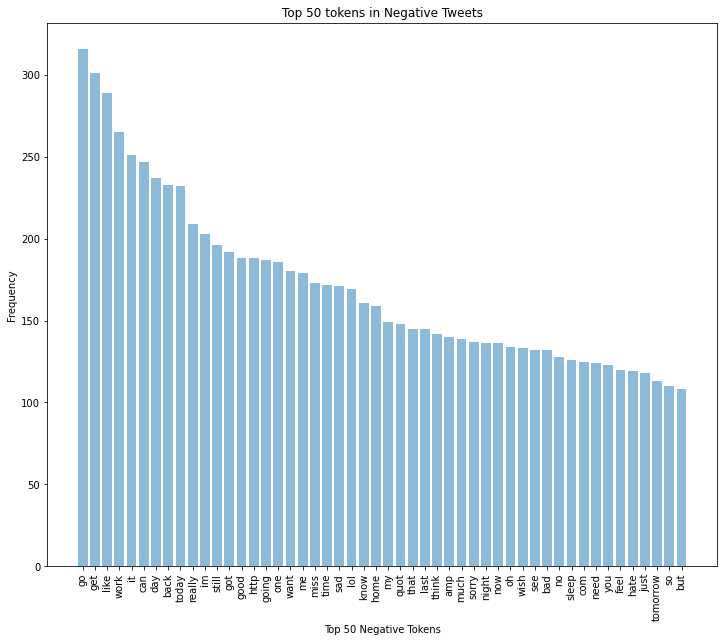

In [10]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, 
        term_freq_df.sort_values(by='negative',ascending=False)       
                                  ['negative'][:50], 
                                  align='center', 
                                  alpha=0.5)
plt.xticks(y_pos, 
           term_freq_df.sort_values(by='negative',ascending=False) 
                                     ['negative']   
                                     [:50].index,
                                     rotation='vertical')
plt.ylabel('Frequency')
plt.title('Top 50 tokens in Negative Tweets')
plt.xlabel('Top 50 Negative Tokens')
plt.show()

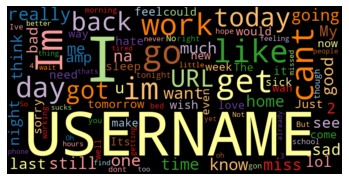

In [11]:
neg_word_freq = count_words(dftrain[dftrain["polarity"] == 0])
wordcloud(neg_word_freq['freq'], max_words=100, 
          stopwords=neg_word_freq.head(50).index)

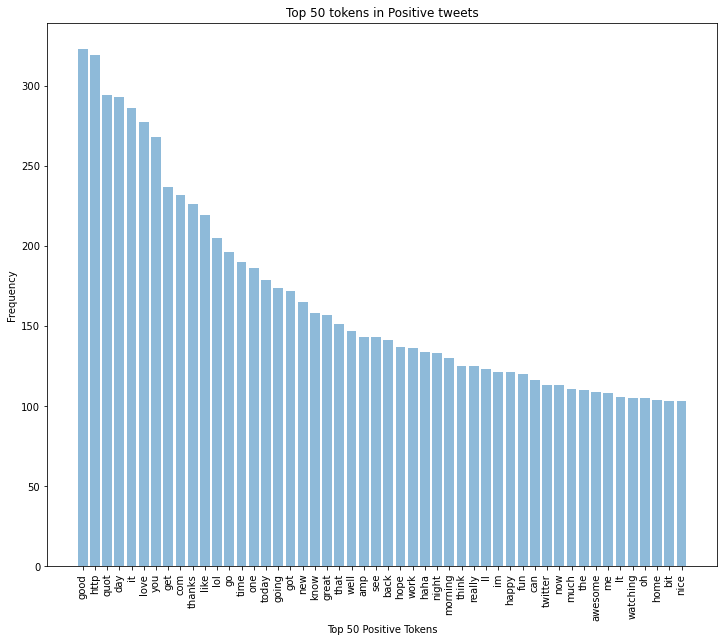

In [12]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, 
        term_freq_df.sort_values(by='positive',ascending=False)       
                                  ['positive'][:50], 
                                  align='center', 
                                  alpha=0.5)
plt.xticks(y_pos, 
           term_freq_df.sort_values(by='positive',ascending=False) 
                                     ['positive']   
                                     [:50].index,
                                     rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 Positive Tokens')
plt.title('Top 50 tokens in Positive tweets')
plt.show()

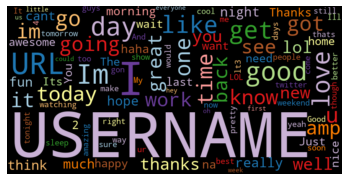

In [13]:
pos_word_freq = count_words(dftrain[dftrain["polarity"] == 4])
wordcloud(pos_word_freq['freq'], max_words=100, 
          stopwords=pos_word_freq.head(50).index)

### Train and test model

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import preprocessing

sentiment_lr = Pipeline([('pre_processor', p),
                         ('cvect', CountVectorizer(min_df = 50)),
                         ("scaler", preprocessing.StandardScaler(with_mean=False)),
                         ('lr', LogisticRegression())])

sentiment_lr.fit(dftrain.text, dftrain.polarity)


#all test 
Xtest, ytest = dftest.text, dftest.polarity
print(classification_report(ytest,sentiment_lr.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.53      0.75      0.62       177
           2       0.00      0.00      0.00       139
           4       0.47      0.63      0.54       182

    accuracy                           0.50       498
   macro avg       0.33      0.46      0.39       498
weighted avg       0.36      0.50      0.42       498



c:\Users\lshpaner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lshpaner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lshpaner\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [15]:
# test

class FinalModel:
  def __init__(self, sentiment_model, dangerous_tags):
      self.model = sentiment_model ##LR
      self.tags = dangerous_tags ##LR
  def predict(self, text):
      out = self.model.predict_proba(text)
      print(out)
      score = 0
      if out[0][0] > 0.60: score = -1
      elif out[0][1] > 0.60: score =  1

      tok = self.model.named_steps['cvect'].transform([text])
      word_list = self.model.named_steps['cvect'].get_feature_names_out()
      count_list = tok.toarray().sum(axis=0)
      o = dict(zip(word_list,count_list)) #this is the features used to predict!

      flag = False
      print(text)
      for char in text.split( ): 
          if char in self.tags: flag = True
              

      return (score, flag)

        
dangerous_tags = {"kill","killed", "shoot", "attack", "hurt","gun","guns", \
        "weapon", "die", "bleed", "suicide","shooting","rifle", "choke", \
        "punch","massacre","shooting","pain","revenge","bomb", \
        "destroy","Stick","Knife","Blade","Club","Ax","Sword",\
        "Spear","Halberd","Pike","Lance","Revolver","Rifle", \
        "Shotgun","Semi Automatic Gun","Fully Automatic Gun",\
        "Machine Gun","Crossbow","Flamethrower","Grenade",\
        "Nerve Gas","Mustard Gas","Tear Gas","Pepper Spray", "AR15","AR-15"}

model = FinalModel(sentiment_model=sentiment_lr, dangerous_tags=dangerous_tags)

### Test model with designed examples 

In [16]:

text = "Hello big beautiful world"
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "I hate this stupid world!!"
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "I will hurt you tomorrow"
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "That movie killed me! It was great"
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "Im going to punch the stupid teacher tomorrow!"
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "I like fruit punch" #testing bad spelling 
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "i enjoy to kill zombies on my playstation!" #testing bad spelling 
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "Just got out of shooting practice" #testing bad spelling 
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "Im bringing my AR15 to hurt everyone" #testing bad spelling 
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "I like shooting my AR-15 after school" #testing bad spelling 
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "I am going to shoot you" #testing bad spelling 
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

text = "I was going shooting tommorow but I hurn my hand." #testing bad spelling 
print(text)
pred = model.predict(text)
print("Sentiment score: {} \t is it dangerous: {}".format(pred, \
    True if pred[0]==-1 and pred[1]==True else False))
print("\n")

Hello big beautiful world
[[0.62011331 0.37988669]]
Hello big beautiful world
Sentiment score: (-1, False) 	 is it dangerous: False


I hate this stupid world!!
[[0.91552554 0.08447446]]
I hate this stupid world!!
Sentiment score: (-1, False) 	 is it dangerous: False


I will hurt you tomorrow
[[0.44506316 0.55493684]]
I will hurt you tomorrow
Sentiment score: (0, True) 	 is it dangerous: False


That movie killed me! It was great
[[0.19477312 0.80522688]]
That movie killed me! It was great
Sentiment score: (1, True) 	 is it dangerous: False


Im going to punch the stupid teacher tomorrow!
[[0.68567599 0.31432401]]
Im going to punch the stupid teacher tomorrow!
Sentiment score: (-1, True) 	 is it dangerous: True


I like fruit punch
[[0.61017431 0.38982569]]
I like fruit punch
Sentiment score: (-1, True) 	 is it dangerous: True


i enjoy to kill zombies on my playstation!
[[0.68918074 0.31081926]]
i enjoy to kill zombies on my playstation!
Sentiment score: (-1, True) 	 is it dangerous:

## Topic Modelling

In [17]:
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

In [18]:
# TF-IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_text_vectorizer = TfidfVectorizer(stop_words=stop, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(dftrain['text'])
tfidf_text_vectors.shape

(10000, 2042)

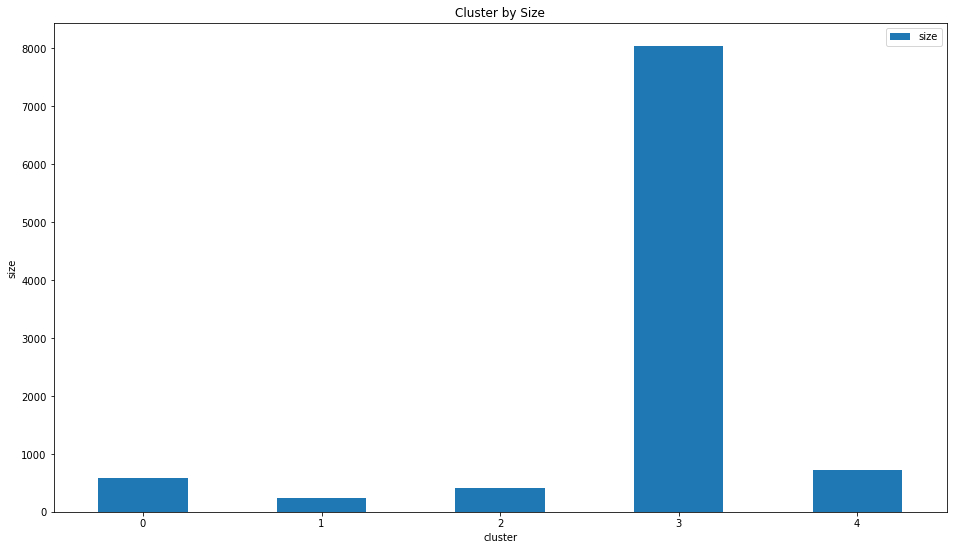

In [19]:
from sklearn.cluster import KMeans

k_means_text = KMeans(n_clusters=5, random_state=42)
model = k_means_text.fit(tfidf_text_vectors)

np.unique(model.labels_, return_counts=True)

sizes = []
for i in range(5):
    sizes.append({"cluster": i, "size": np.sum(model.labels_==i)})
pd.DataFrame(sizes).set_index("cluster").plot.bar(figsize=(16,9))
plt.xticks(rotation=0)
plt.title('Cluster by Size')
plt.ylabel('size')
plt.show()

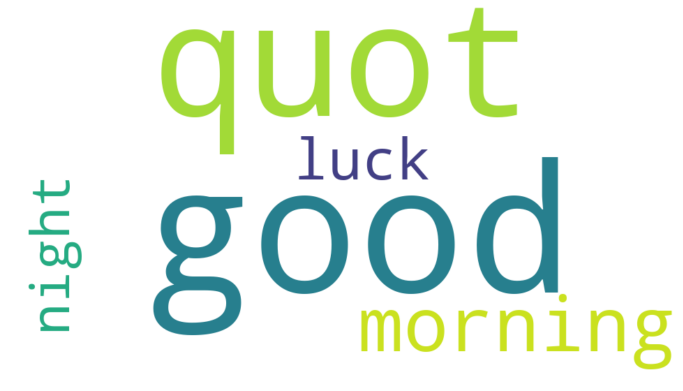

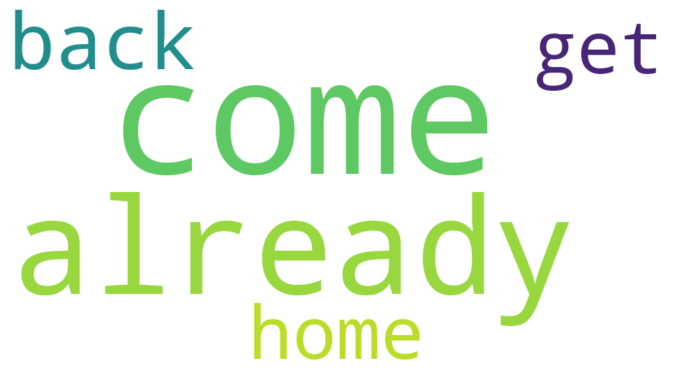

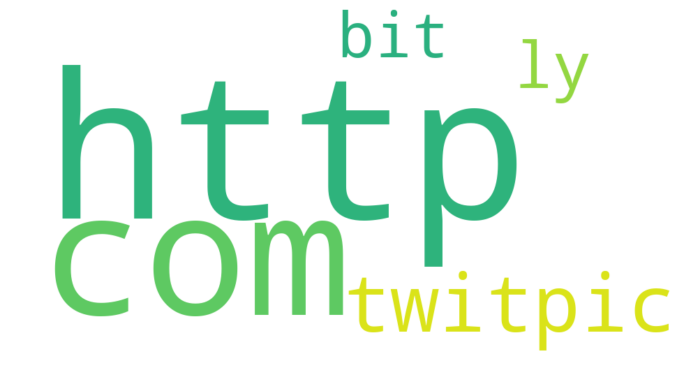

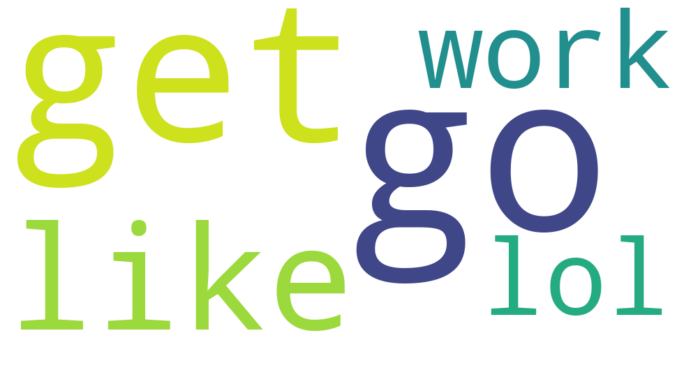

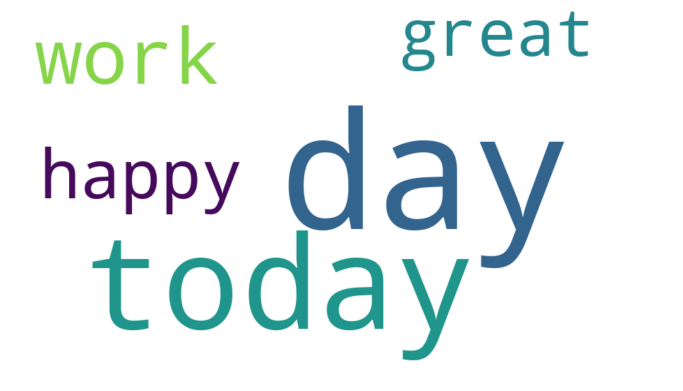

In [20]:
wordcloud_clusters(model, tfidf_text_vectors,
                   tfidf_text_vectorizer.get_feature_names())

In [21]:
# Fitting an LSA Model

svd_text_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

# call display_topics 
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  good (1.50)
  http (1.42)
  com (1.27)
  day (1.25)
  work (1.07)

Topic 01
  http (18.65)
  com (17.62)
  twitpic (10.92)
  plurk (3.62)
  ly (3.16)

Topic 02
  good (19.57)
  morning (7.17)
  day (2.73)
  luck (1.88)
  com (1.77)

Topic 03
  quot (72.66)
  good (23.88)
  morning (8.09)
  thanks (3.02)
  luck (2.47)

Topic 04
  thanks (32.76)
  lol (8.12)
  love (6.96)
  im (3.38)
  sorry (2.72)
